# Paper Figure 6: Quantification



In [1]:
import os
from test_files import get_files, prepare_test
from alphapept.quantification import protein_profile_parallel_mq
import pandas as pd
import numpy as np
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt

def get_species(valid):

    homo = valid[valid['Species'] == 'Homo sapiens']
    e_coli = valid[valid['Species'] == 'Escherichia coli']
    
    return homo, e_coli

In [2]:
#MaxQuant 2.1.4.0

tmp_folder = 'F:/projects/alphapept/sandbox/temp'
test_folder = 'fig6'


files = ['PXD006109_MQ_2_1_4_0_PG.txt', 'PXD006109_MQ_2_1_4_0_EV.txt']

get_files(tmp_folder, files)
prepare_test(files, tmp_folder, test_folder)

evidence_path = os.path.join(tmp_folder, test_folder, files[1])
protein_group_path = os.path.join(tmp_folder, test_folder, files[0])

Creating dir F:/projects/alphapept/sandbox/temp\fig6.


In [3]:
%%time

pt = protein_profile_parallel_mq(evidence_path, protein_group_path)

CPU times: total: 2min 23s
Wall time: 2min 32s


In [4]:
ref = pd.read_csv(protein_group_path, sep='\t')
ref = ref.replace(0, np.nan)

species = []
for _ in ref['Protein IDs']:
    
    if 'HUM' in _:
        species.append('Homo sapiens')
        
    elif 'ECO' in _:
        species.append('Escherichia coli')
        
    else:
        species.append('X')
        
ref['Species'] = species

## MaxQuant w/o LFQ

In [5]:
df_= ref.copy()
ds = [_ for _ in df_.columns if 'Intensity' in _]
base_columns = [_ for _ in ds if 'HeLa2' in _]
ratio_columns = [_ for _ in ds if 'HeLa12' in _]
to_plot = pd.DataFrame()
to_plot['Species'] = df_['Species']
to_plot['base'] = df_[base_columns].median(axis=1)
to_plot['ratio'] = df_[ratio_columns].median(axis=1)
to_plot['base_cnt'] = df_[base_columns].notna().sum(axis=1)
to_plot['ratio_cnt'] = df_[ratio_columns].notna().sum(axis=1)
to_plot['ratio_'] = np.log2(to_plot['base'] / to_plot['ratio'])
to_plot['sum_'] = np.log2(to_plot['ratio'])
valid_mq_nolfq = to_plot.query(f'ratio_cnt >= 2 and base_cnt >=2')

mean_cv_base = (df_[base_columns].std(axis=1)/df_[base_columns].mean(axis=1)).mean()
print(f"Mean CV {mean_cv_base:.2f}")

Mean CV 0.33


## MaxQuant w/ LFQ

In [6]:
df_= ref.copy()
ds = [_ for _ in df_.columns if 'LFQ intensity' in _]
base_columns = [_ for _ in ds if 'HeLa2' in _]
ratio_columns = [_ for _ in ds if 'HeLa12' in _]
to_plot = pd.DataFrame()
to_plot['Species'] = df_['Species']
to_plot['base'] = df_[base_columns].median(axis=1)
to_plot['ratio'] = df_[ratio_columns].median(axis=1)
to_plot['base_cnt'] = df_[base_columns].notna().sum(axis=1)
to_plot['ratio_cnt'] = df_[ratio_columns].notna().sum(axis=1)
to_plot['ratio_'] = np.log2(to_plot['base'] / to_plot['ratio'])
to_plot['sum_'] = np.log2(to_plot['ratio'])
valid_mq = to_plot.query(f'ratio_cnt >= 2 and base_cnt >=2')

mean_cv_base = (df_[base_columns].std(axis=1)/df_[base_columns].mean(axis=1)).mean()
print(f"Mean CV {mean_cv_base:.2f}")

Mean CV 0.16


## AlphaPept on MQ

In [7]:
lookup_dict = dict(zip(ref['Protein IDs'].values, ref['Species'].values))

In [8]:
import numpy as npa
df_ = pt.copy()
df_['Species'] = [lookup_dict[_] for _ in df_.index]

ds = [_ for _ in df_.columns if 'LFQ' in _]
base_columns = [_ for _ in ds if 'HeLa2' in _]
ratio_columns = [_ for _ in ds if 'HeLa12' in _]   
to_plot = pd.DataFrame()
to_plot['Species'] = df_['Species']
to_plot['base'] = df_[base_columns].median(axis=1)
to_plot['ratio'] = df_[ratio_columns].median(axis=1)
to_plot['base_cnt'] = df_[base_columns].notna().sum(axis=1)
to_plot['ratio_cnt'] = df_[ratio_columns].notna().sum(axis=1)
to_plot['ratio_'] = np.log2(to_plot['base'] / to_plot['ratio'])
to_plot['sum_'] = np.log2(to_plot['ratio'])
valid_ap = to_plot.query(f'ratio_cnt >= 2 and base_cnt >=2')

mean_cv_base = (df_[base_columns].std(axis=1)/df_[base_columns].mean(axis=1)).mean()
print(f"Mean CV {mean_cv_base:.2f}")

Mean CV 0.14


In [9]:
homo_mq, e_coli_mq = get_species(valid_mq)
homo_mq, e_coli_mq_nolfq = get_species(valid_mq_nolfq)
homo_ap, e_coli_ap = get_species(valid_ap)

In [10]:
hfont = {'fontname':'Arial', 'size':10}

dark_blue = '#17212b'
light_blue = '#3dc5ef'
teal= '#42dee1'
green = '#6eecb9'
yellow = '#eef5b3'

figsize= (2.363,2.363)

In [11]:
len(valid_mq_nolfq), len(valid_mq), len(valid_ap)

(4699, 4475, 4647)

Homo 0.36
Ecoli 1.05


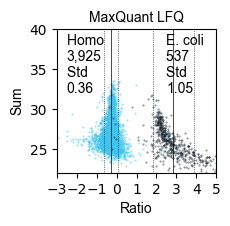

Homo 0.68
Ecoli 1.00


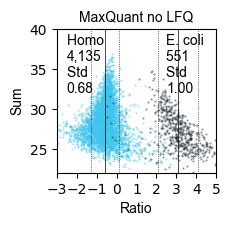

Homo 0.30
Ecoli 0.54


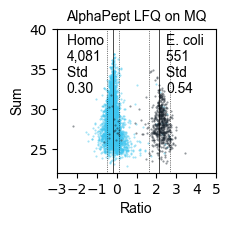

In [12]:
for _ in [(valid_mq, 'MaxQuant LFQ', 'mq'), (valid_mq_nolfq, 'MaxQuant no LFQ', 'mq_nolfq') , (valid_ap, 'AlphaPept LFQ on MQ', 'ap_lfq')]:
    
    valid, title, filename = _
    
    homo_, e_coli_ = get_species(valid)

    plt.figure(figsize=figsize) #60x60
    plt.plot(homo_['ratio_'], homo_['sum_'], '.', alpha=0.5, color = light_blue, markersize=1)
    plt.plot(e_coli_['ratio_'], e_coli_['sum_'], '.', alpha=0.5, color = dark_blue, markersize=1)

    mean_ = homo_['ratio_'].mean()
    std_ = homo_['ratio_'].std()
    plt.axvline(mean_, color = 'k', linewidth=0.5)
    plt.axvline(mean_+std_, linestyle=':', color='k', linewidth=0.5)
    plt.axvline(mean_-std_,  linestyle=':', color='k', linewidth=0.5)

    print(f'Homo {std_:.2f}')
    plt.text(-2.5, 32, f'Homo \n{len(homo_):,}\nStd \n{std_:.2f}', **hfont)

    mean_ = e_coli_['ratio_'].mean()
    std_ = e_coli_['ratio_'].std()
    plt.axvline(mean_, color = 'k', linewidth=0.5)
    plt.axvline(mean_+std_, linestyle=':', color='k', linewidth=0.5)
    plt.axvline(mean_-std_,  linestyle=':', color='k', linewidth=0.5)

    print(f'Ecoli {std_:.2f}')

    plt.text(2.5, 32, f'E. coli\n{len(e_coli_):,} \nStd \n{std_:.2f}', **hfont)

    plt.xlim([-3, 5])
    plt.ylim([22, 40])
    ax = plt.gca()

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    plt.xlabel('Ratio', **hfont)
    plt.ylabel('Sum', **hfont)
    plt.title(title, **hfont)
    plt.tight_layout()
    plt.xticks([-3,-2,-1,0,1,2,3,4,5])
    plt.savefig(f'figures/06_{filename}.pdf')
    plt.show()